# ANN

Table of Contents
- [1. Preprocessing Data](#1-preprocessing-the-data)
- [2. Model for Calls ONLY](#2-model-for-calls-only)
  - [2.1 Stage 1 Model (Binary Classifier)](#21-stage-1-model-binary-classifier)
  - [2.2 Stage 2 Model (Price Prediction)](#22-stage-2-model-price-prediction)
  - [2.3 Testing model](#23-testing-model)
  - [2.4 Hyper param Tuning](#24-hyperparam-tuning)
    - [2.4.1 Hyperparam Tuning (Binary Classifier)](#241-hyperparam-tuning-binary-classifier)
    - [2.4.2 Hyperparam Tuning (Price Prediction)](#242-hyperparam-tuning-price-prediction)
- [3. Model for Puts ONLY](#3-model-for-puts-only)
  - [3.1 Stage 1 Model (Binary Classifier)](#31-stage-1-model-binary-classifier)
  - [3.2 Stage 2 Model (Price Prediction)](#32-stage-2-model-price-prediction)
  - [3.3 Testing model](#33-testing-model)
  - [3.4 Hyper param Tuning](#34-hyperparam-tuning)
    - [3.4.1 Hyperparam Tuning (Binary Classifier)](#341-hyperparam-tuning-binary-classifier)
    - [3.4.2 Hyperparam Tuning (Price Prediction)](#342-hyperparam-tuning-price-prediction)

<u>Stage 1: Binary Classification Model</u>

The first model is responsible for predicting if the option is “purchasable.” It classifies the input based on whether to proceed with price prediction or not.

- Input Layer
    - 15 neurons (one for each input feature).
- Hidden Layer
    - 1 Layer, 30 neurons (Leaky RelU)
- Output Layer
    - 1 neuron with a sigmoid activation function to produce a binary result:
        - Output = 1 if the option is “purchasable” (indicating "Buy the option").
        - Output = 0 if the option is “not purchasable” (indicating "Do not buy").

<u>Stage 2: Price Prediction Model</u>

Only if the classification model predicts the option as “purchasable” (1) does the data proceed to this model. This model predicts the price of the option.

- Input Layer
    - 15 neurons (same input features as the classification model).
- Hidden Layers (Price Prediction Layer)
    - First layer, 30 neurons (Leaky ReLU)
    - Second Layer, 15 neurons (Leaky ReLU)
- Output Layer
    - 1 neuron without activation (for regression) to predict the option price.

# 1. Preprocessing the Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
df1 = pd.read_csv('data/SPX/UnderlyingOptionsIntervals_3600sec_calcs_oi_2024-07-26.csv')
df3 = pd.read_csv('data/SPX/UnderlyingOptionsIntervals_3600sec_calcs_oi_2024-09-27.csv')
df2 = pd.read_csv('data/SPX/UnderlyingOptionsIntervals_3600sec_calcs_oi_2024-08-30.csv')
df4 = pd.read_csv('data/SPX/UnderlyingOptionsIntervals_3600sec_calcs_oi_2024-10-11.csv')
df5 = pd.read_csv('data/SPX/UnderlyingOptionsIntervals_3600sec_calcs_oi_2024-10-18.csv')
df6 = pd.read_csv('data/SPX/UnderlyingOptionsIntervals_3600sec_calcs_oi_2024-10-25.csv')

In [3]:
df_train = pd.concat([
    df1[(df1['root']=='SPX')],
    df2[(df2['root']=='SPX')],
    df3[(df3['root']=='SPX')],
    df4[(df4['root']=='SPX')],
    df5[(df5['root']=='SPX')]
])
df_test = df6[df6['root'] == 'SPX'].copy()

In [4]:
# Transforming relevant columns to datetime
df_train['expiration'] = pd.to_datetime(df_train['expiration'])
df_train['quote_datetime'] = pd.to_datetime(df_train['quote_datetime'])

df_test['expiration'] = pd.to_datetime(df_test['expiration'])
df_test['quote_datetime'] = pd.to_datetime(df_test['quote_datetime'])

# Calculate time-to-expiration as the difference in days
df_train['time_to_expiration'] = (df_train['expiration'] - df_train['quote_datetime']).dt.days
df_test['time_to_expiration'] = (df_test['expiration'] - df_test['quote_datetime']).dt.days

In [5]:
# New column bid_ask_spread
df_train['bid_ask_spread'] = df_train['underlying_ask'] - df_train['underlying_bid']
df_test['bid_ask_spread'] = df_test['underlying_ask'] - df_test['underlying_bid']

In [6]:
# New column is_buy, shows whether an option was bought
df_train['is_buy'] = ((df_train['trade_volume'] > 0) & (df_train['close'] != 0)).astype(int)
df_test['is_buy'] = ((df_test['trade_volume'] > 0) & (df_test['close'] != 0)).astype(int)

In [7]:
df_train_calls = df_train[df_train['option_type']=='C']
df_test_calls = df_test[df_test['option_type']=='C']

df_train_puts = df_train[df_train['option_type']=='P']
df_test_puts = df_test[df_test['option_type']=='P']

In [8]:
df_test_calls.columns

Index(['underlying_symbol', 'quote_datetime', 'root', 'expiration', 'strike',
       'option_type', 'open', 'high', 'low', 'close', 'trade_volume',
       'bid_size', 'bid', 'ask_size', 'ask', 'underlying_bid',
       'underlying_ask', 'implied_underlying_price', 'active_underlying_price',
       'implied_volatility', 'delta', 'gamma', 'theta', 'vega', 'rho',
       'open_interest', 'time_to_expiration', 'bid_ask_spread', 'is_buy'],
      dtype='object')

In [9]:
# Dropping irrelevant columns
# root, underlying_symbol, option_type, implied_underlying_price, quote_datetime, expiration, bid_size, ask_size, underlying_bid, underlying_ask, open, high, low
columns_to_drop = ['root', 'option_type','underlying_symbol', 'implied_underlying_price', 'quote_datetime', 
                   'expiration', 'open', 'high', 'low', 'bid_size', 'ask_size', 
                   'underlying_bid', 'underlying_ask']

df_train_calls = df_train_calls.drop(columns = columns_to_drop, axis=1)
df_train_puts = df_train_puts.drop(columns = columns_to_drop, axis=1)
df_test_calls = df_test_calls.drop(columns = columns_to_drop, axis=1)
df_test_puts = df_test_puts.drop(columns = columns_to_drop, axis=1)

# 2. Model for Calls ONLY

In [10]:
# Scaling features
from sklearn.preprocessing import StandardScaler

numerical_columns = ['strike', 'trade_volume', 'active_underlying_price', 
                     'implied_volatility', 'delta', 'gamma', 'theta', 
                     'vega', 'rho', 'open_interest', 'time_to_expiration', 'bid_ask_spread']
scaler = StandardScaler()
df_train_calls[numerical_columns] = scaler.fit_transform(df_train_calls[numerical_columns])
df_test_calls[numerical_columns] = scaler.transform(df_test_calls[numerical_columns])

## 2.1 Stage 1 Model (Binary Classifier)

The followering hyper parameters were determined in [Section 2.4.1](#241-hyperparam-tuning-binary-classifier) of hyperparameter tuning.
- Hidden Layer No. of Neurons: 14
- Model Learning Rate: 0.001
- Epochs: 20
- Batch Size: 16

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam

# Define the binary classifier model
binary_classifier_calls = Sequential()

# Input layer with 14 neurons for 14 features
binary_classifier_calls.add(Input(shape=(14,)))

# Hidden layer with 56 neurons
binary_classifier_calls.add(Dense(units=14))
binary_classifier_calls.add(LeakyReLU(negative_slope=0.01))         # Leaky ReLU activation

# Output layer with 1 neuron and sigmoid activation for binary classification
binary_classifier_calls.add(Dense(1, activation='sigmoid'))

# Compile the model with binary cross-entropy loss and Adam optimizer
binary_classifier_calls.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
binary_classifier_calls.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 14)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225 (900.00 B)

 Trainable params: 225 (900.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Separate features and target for training
X_train = df_train_calls.drop(columns=['close', 'is_buy'])  # Drop 'close' and 'is_buy' from features
y_train = df_train_calls['is_buy']  # Target for binary classification

In [13]:
# Training the binary classifier
history = binary_classifier_calls.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)


Epoch 1/20
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 2s 261us/step - accuracy: 0.9441 - loss: 0.6018 - val_accuracy: 0.9542 - val_loss: 0.1703
Epoch 2/20
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 2s 240us/step - accuracy: 0.9568 - loss: 0.1804 - val_accuracy: 0.9607 - val_loss: 0.1401
Epoch 3/20
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 2s 240us/step - accuracy: 0.9613 - loss: 0.1459 - val_accuracy: 0.9630 - val_loss: 0.1314
Epoch 4/20
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 2s 242us/step - accuracy: 0.9635 - loss: 0.1439 - val_accuracy: 0.9619 - val_loss: 0.1293
Epoch 5/20
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 2s 244us/step - accuracy: 0.9655 - loss: 0.1348 - val_accuracy: 0.9613 - val_loss: 0.2331
Epoch 6/20
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 2s 236us/step - accuracy: 0.9665 - loss: 0.1264 - val_accuracy: 0.9619 - val_loss: 0.2360
Epoch 7/20
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 2s 240us/step - accuracy: 0.9681 - loss: 0.1268 - val_accuracy: 0.9671 - val_loss: 0.1102
Epoch 8/20
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 2s 237us/step - accuracy: 0.9691 -

In [14]:
# Separate features and target for the price prediction model
X_train_calls = df_train_calls.drop(columns=['is_buy','close'])  # Features for price prediction
y_train_price_full = df_train_calls['close']  # Target price

# Generate the 'purchasable' predictions using the classifier
purchasable_mask = binary_classifier_calls.predict(X_train_calls) >= 1  # Prediction mask for purchasable options

# Filter rows for the price prediction model based on the 'purchasable' mask
X_train_price = X_train_calls[purchasable_mask.flatten()]  # Only rows classified as purchasable
y_train_price = y_train_price_full[purchasable_mask.flatten()]  # Corresponding target prices for purchasable options

4312/4312 ━━━━━━━━━━━━━━━━━━━━ 1s 178us/step


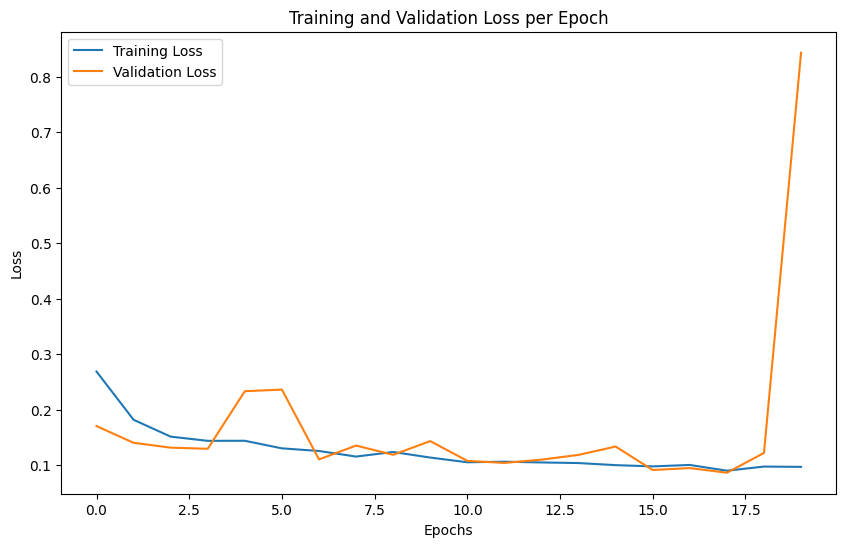

In [15]:
import matplotlib.pyplot as plt
# Extracting training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the losses per epoch
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

## 2.2 Stage 2 Model (Price Prediction)

The followering hyper parameters were determined in [Section 2.4.2](#242-hyperparam-tuning-price-prediction) of hyperparameter tuning.
- Hidden Layer 1 No. of Neurons: 14
- Hidden Layer 2 No. of Neurons: 7
- Model Learning Rate: 0.001
- Epochs: 20
- Batch Size: 64

In [16]:
# Define the price prediction model
price_prediction_model_calls = Sequential()

# Input layer with 14 neurons
price_prediction_model_calls.add(Input(shape=(14,))) # 14 input features

# First hidden layer with 14 neurons
price_prediction_model_calls.add(Dense(units=14))  # 14 neurons
price_prediction_model_calls.add(LeakyReLU(negative_slope=0.01))               # Leaky ReLU activation

# Second hidden layer with 7 neurons and Leaky ReLU activation
price_prediction_model_calls.add(Dense(units=7))
price_prediction_model_calls.add(LeakyReLU(negative_slope=0.01))

# Output layer with 1 neuron (no activation for regression)
price_prediction_model_calls.add(Dense(units=1))

# Compile the model with Mean Squared Error (MSE) as the loss function for regression
price_prediction_model_calls.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Summary of the model architecture
price_prediction_model_calls.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 14)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 323 (1.26 KB)

 Trainable params: 323 (1.26 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Train the price prediction model
history = price_prediction_model_calls.fit(X_train_price, y_train_price, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 103260.6016 - val_loss: 143773.9219
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 89792.4766 - val_loss: 127576.1484
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 74587.9688 - val_loss: 113478.9609
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 102259.0938 - val_loss: 97543.2188
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 131614.5000 - val_loss: 83104.8047
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 105517.7812 - val_loss: 68666.8359
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 65356.3125 - val_loss: 53431.0820
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 51401.4141 - val_loss: 39562.7812
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 37742.3242 - val_loss: 26569.8633
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 32698.0918 - val_loss: 17441.2227
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss:

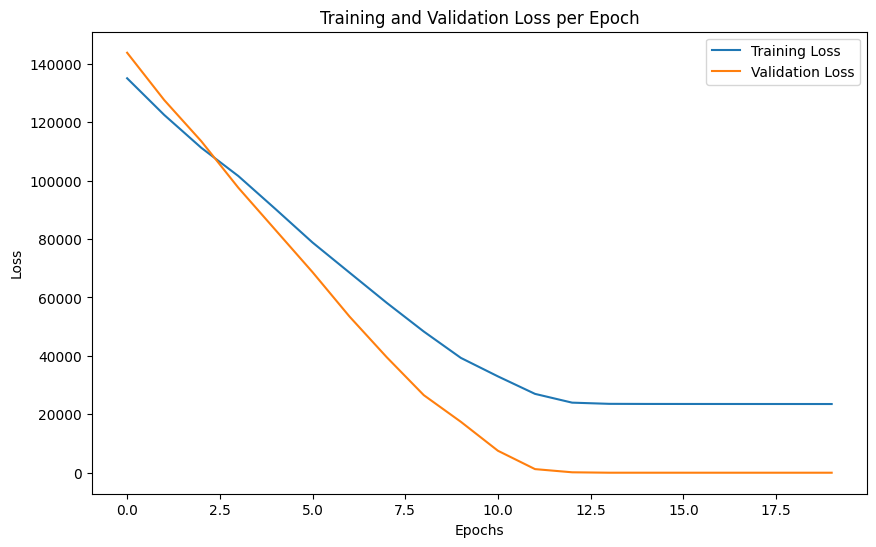

In [18]:
# Extracting training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the losses per epoch
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

## 2.3 Testing model

Testing is performed on a 6th day of trading not included in the training data

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [20]:
# Features and target for binary classification model
X_test_classification = df_test_calls.drop(columns=['close', 'is_buy'])  # Features for binary classification
y_test_classification = df_test_calls['is_buy']           # Binary target for classification

# Features and target for price prediction model
X_test_price = df_test_calls.drop(columns=['is_buy', 'close'])  # Features for price prediction
y_test_price_full = df_test_calls['close']                      # Target price for price prediction

In [21]:
y_pred_binary = (binary_classifier_calls.predict(X_test_classification).flatten() >= 0.5).astype(int)

# Calculate binary classifier metrics
binary_accuracy = accuracy_score(y_test_classification, y_pred_binary)
binary_precision = precision_score(y_test_classification, y_pred_binary)
binary_recall = recall_score(y_test_classification, y_pred_binary)
binary_f1 = f1_score(y_test_classification, y_pred_binary)

print("Binary Classifier Metrics:")
print(f"Accuracy: {binary_accuracy}")
print(f"Precision: {binary_precision}")
print(f"Recall: {binary_recall}")
print(f"F1-Score: {binary_f1}")


872/872 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step
Binary Classifier Metrics:
Accuracy: 0.967493369650921
Precision: 1.0
Recall: 0.3904569892473118
F1-Score: 0.5616239729337844


In [22]:
# Step 2: Filter Data for Stage 2 Price Prediction
purchasable_mask = (y_pred_binary == 1)  # Mask for options classified as "purchasable"

# Apply the mask to get features and target for price prediction
X_test_price_purchasable = X_test_price[purchasable_mask]
y_test_price = y_test_price_full[purchasable_mask]

In [23]:
# Step 3: Run Stage 2 Price Prediction
if len(X_test_price_purchasable) > 0:
    y_pred_price = price_prediction_model_calls.predict(X_test_price_purchasable)

    # Calculate regression metrics
    mse = mean_squared_error(y_test_price, y_pred_price)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_price, y_pred_price)
    r2 = r2_score(y_test_price, y_pred_price)

    print("\nPrice Prediction Model Metrics:")
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R-squared: {r2}")
else:
    print("\nNo 'purchasable' options found for price prediction in the 6th day test set.")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step

Price Prediction Model Metrics:
Mean Squared Error: 14.576520811790418
Root Mean Squared Error: 3.8179210064890574
Mean Absolute Error: 2.953891297755267
R-squared: 0.9998852391705698


## 2.4 Hyperparam Tuning

### 2.4.1 Hyperparam Tuning (Binary Classifier)

In [22]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV 

In [23]:
# Define the model-building function for Random Search
def build_binary_classifier_model(units=28, learning_rate=1e-3):
    model = Sequential()
    
    # Define the input layer separately using Input()
    model.add(Input(shape=(14,)))
    
    # Hidden layer with Leaky ReLU activation (using `negative_slope` instead of `alpha`)
    model.add(Dense(units=units))
    model.add(LeakyReLU(negative_slope=0.01))
    
    # Output layer with 1 neuron and sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model with specified learning rate
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Wrap the model using KerasClassifier, passing the function as build_fn
binary_classifier = KerasClassifier(model=build_binary_classifier_model, verbose=0)


In [24]:
param_grid = {
    'model__units': [14, 28, 56],            # Number of neurons in the hidden layer
    'model__learning_rate': [1e-2, 1e-3, 1e-4],  # Learning rates to try
    'batch_size': [16, 32, 64],              # Batch sizes to try
    'epochs': [10, 20]                       # Number of epochs to train
}

In [25]:
# Initialize RandomizedSearchCV with the desired number of iterations
random_search = RandomizedSearchCV(estimator=binary_classifier, param_distributions=param_grid, 
                                   scoring='accuracy', cv=3, n_iter=10, random_state=42)

# Fit RandomizedSearchCV
X_train = df_train_calls.drop(columns=['close', 'is_buy'])  # Drop 'close' and 'is_buy' from features
y_train = df_train_calls['is_buy']  # Target for binary classification
random_search_result = random_search.fit(X_train, y_train)

# Get the best hyperparameters and score
print(f"Best Hyperparameters: {random_search_result.best_params_}")
print(f"Best Score: {random_search_result.best_score_}")


Best Hyperparameters: {'model__units': 14, 'model__learning_rate': 0.001, 'epochs': 20, 'batch_size': 16}
Best Score: 0.9740424311850773


### 2.4.2 Hyperparam Tuning (Price Prediction)

In [26]:
from scikeras.wrappers import KerasRegressor

In [27]:
# Define the model-building function
def build_price_prediction_model(units1=28, units2=14, learning_rate=1e-3):
    model = Sequential()
    
    # Input and first hidden layer
    model.add(Input(shape=(14,)))
    model.add(Dense(units=units1))
    model.add(LeakyReLU(negative_slope=0.01))
    
    # Second hidden layer
    model.add(Dense(units=units2))
    model.add(LeakyReLU(negative_slope=0.01))
    
    # Output layer
    model.add(Dense(units=1))  # No activation function for regression
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

In [28]:
# Wrap the model with KerasRegressor
price_prediction_model = KerasRegressor(model=build_price_prediction_model, verbose=0)

In [29]:
param_grid = {
    'model__units1': [14, 28, 54],               # Number of neurons in the first hidden layer
    'model__units2': [7, 14, 28],                # Number of neurons in the second hidden layer
    'model__learning_rate': [1e-2, 1e-3, 1e-4],  # Learning rates to try
    'batch_size': [16, 32, 64],                  # Batch sizes to try
    'epochs': [10, 20]                           # Number of epochs
}

In [30]:
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=price_prediction_model, param_distributions=param_grid, 
                                   scoring='neg_mean_squared_error', n_iter=10, cv=3, random_state=42)

# Fit RandomizedSearchCV
X_train = df_train_calls.drop(columns=['close', 'is_buy'])  # Features for training
y_train = df_train_calls['close']  # Target prices for training
random_search_result = random_search.fit(X_train, y_train)

# Get the best hyperparameters and score
print(f"Best Hyperparameters: {random_search_result.best_params_}")
print(f"Best Score (Negative MSE): {random_search_result.best_score_}")


Best Hyperparameters: {'model__units2': 7, 'model__units1': 14, 'model__learning_rate': 0.001, 'epochs': 20, 'batch_size': 64}
Best Score (Negative MSE): -11932.170982849595


# 3. Model for Puts ONLY

In [24]:
# Scaling
numerical_columns = ['strike', 'trade_volume', 'active_underlying_price', 
                     'implied_volatility', 'delta', 'gamma', 'theta', 
                     'vega', 'rho', 'open_interest', 'time_to_expiration', 'bid_ask_spread']
scaler = StandardScaler()
df_train_puts[numerical_columns] = scaler.fit_transform(df_train_puts[numerical_columns])
df_test_puts[numerical_columns] = scaler.transform(df_test_puts[numerical_columns])

## 3.1 Stage 1 Model (Binary Classifier)

The followering hyper parameters were determined in [Section 3.4.1](#341-hyperparam-tuning-binary-classifier) of hyperparameter tuning.
- Hidden Layer No. of Neurons: 56
- Model Learning Rate: 0.001
- Epochs: 20
- Batch Size: 32

In [25]:
# Define the binary classifier model
binary_classifier_puts = Sequential()

# Input layer with 14 neurons for 14 features
binary_classifier_puts.add(Input(shape=(14,)))

# Hidden layer with 56 neurons
binary_classifier_puts.add(Dense(units=56))
binary_classifier_puts.add(LeakyReLU(negative_slope=0.01))         # Leaky ReLU activation

# Output layer with 1 neuron and sigmoid activation for binary classification
binary_classifier_puts.add(Dense(1, activation='sigmoid'))

# Compile the model with binary cross-entropy loss and Adam optimizer
binary_classifier_puts.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
binary_classifier_puts.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 56)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            57 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 897 (3.50 KB)

 Trainable params: 897 (3.50 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Separate features and target for training
X_train = df_train_puts.drop(columns=['close', 'is_buy'])  # Drop 'close' and 'is_buy' from features
y_train = df_train_puts['is_buy']  # Target for binary classification

In [27]:
# Training the binary classifier
history = binary_classifier_puts.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
3449/3449 ━━━━━━━━━━━━━━━━━━━━ 1s 258us/step - accuracy: 0.9058 - loss: 0.3268 - val_accuracy: 0.9104 - val_loss: 0.2507
Epoch 2/20
3449/3449 ━━━━━━━━━━━━━━━━━━━━ 1s 258us/step - accuracy: 0.9271 - loss: 0.2865 - val_accuracy: 0.9157 - val_loss: 0.2798
Epoch 3/20
3449/3449 ━━━━━━━━━━━━━━━━━━━━ 1s 250us/step - accuracy: 0.9374 - loss: 0.2195 - val_accuracy: 0.9341 - val_loss: 0.1939
Epoch 4/20
3449/3449 ━━━━━━━━━━━━━━━━━━━━ 1s 252us/step - accuracy: 0.9444 - loss: 0.2068 - val_accuracy: 0.9198 - val_loss: 0.8000
Epoch 5/20
3449/3449 ━━━━━━━━━━━━━━━━━━━━ 1s 245us/step - accuracy: 0.9444 - loss: 0.2301 - val_accuracy: 0.9465 - val_loss: 0.1725
Epoch 6/20
3449/3449 ━━━━━━━━━━━━━━━━━━━━ 1s 244us/step - accuracy: 0.9491 - loss: 0.1959 - val_accuracy: 0.9476 - val_loss: 0.1714
Epoch 7/20
3449/3449 ━━━━━━━━━━━━━━━━━━━━ 1s 256us/step - accuracy: 0.9503 - loss: 0.1983 - val_accuracy: 0.9455 - val_loss: 0.2110
Epoch 8/20
3449/3449 ━━━━━━━━━━━━━━━━━━━━ 1s 257us/step - accuracy: 0.9541 -

In [28]:
# Separate features and target for the price prediction model
X_train_puts = df_train_puts.drop(columns=['is_buy','close'])  # Features for price prediction
y_train_price_full = df_train_puts['close']  # Target price

# Generate the 'purchasable' predictions using the classifier
purchasable_mask = binary_classifier_puts.predict(X_train_puts) >= 1  # Prediction mask for purchasable options

# Filter rows for the price prediction model based on the 'purchasable' mask
X_train_price = X_train_puts[purchasable_mask.flatten()]  # Only rows classified as purchasable
y_train_price = y_train_price_full[purchasable_mask.flatten()]  # Corresponding target prices for purchasable options

4312/4312 ━━━━━━━━━━━━━━━━━━━━ 1s 167us/step


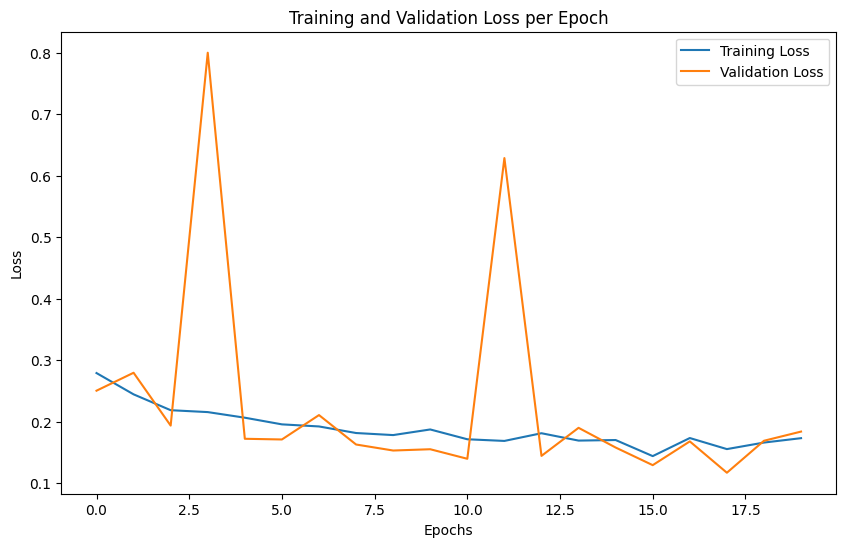

In [29]:
# Extracting training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the losses per epoch
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

## 3.2 Stage 2 Model (Price Prediction)

The followering hyper parameters were determined in [Section 3.4.2](#342-hyperparam-tuning-price-prediction) of hyperparameter tuning.
- Hidden Layer 1 No. of Neurons: 28
- Hidden Layer 2 No. of Neurons: 14
- Model Learning Rate: 0.01
- Epochs: 20
- Batch Size: 32

In [30]:
# Define the price prediction model
price_prediction_model_puts = Sequential()

# Input layer with 14 neurons and first hidden layer with 14 neurons
price_prediction_model_puts.add(Input(shape=(14,)))
price_prediction_model_puts.add(Dense(units=28))
price_prediction_model_puts.add(LeakyReLU(negative_slope=0.01))               # Leaky ReLU activation

# Second hidden layer with 28 neurons and Leaky ReLU activation
price_prediction_model_puts.add(Dense(units=14))
price_prediction_model_puts.add(LeakyReLU(negative_slope=0.01))

# Output layer with 1 neuron (no activation for regression)
price_prediction_model_puts.add(Dense(units=1))

# Compile the model with Mean Squared Error (MSE) as the loss function for regression
price_prediction_model_puts.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# Summary of the model architecture
price_prediction_model_puts.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 28)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 14)             │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 841 (3.29 KB)

 Trainable params: 841 (3.29 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Train the price prediction model
history = price_prediction_model_puts.fit(X_train_price, y_train_price, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 1106.7775 - val_loss: 1.1815
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - loss: 5.1803 - val_loss: 2.8839
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 3.9622 - val_loss: 32.2990
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step - loss: 11.6203 - val_loss: 1.0559
Epoch 5/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step - loss: 7.2880 - val_loss: 1.1260
Epoch 6/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step - loss: 9.3945 - val_loss: 14.9119
Epoch 7/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step - loss: 8.9943 - val_loss: 1.1788
Epoch 8/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 6.0700 - val_loss: 61.8190
Epoch 9/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - loss: 18.5797 - val_loss: 1.5227
Epoch 10/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - loss: 4.0851 - val_loss: 8.9088
Epoch 11/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 24.4091 - val_loss: 1.9174
Epoch 12/20
135/135 ━

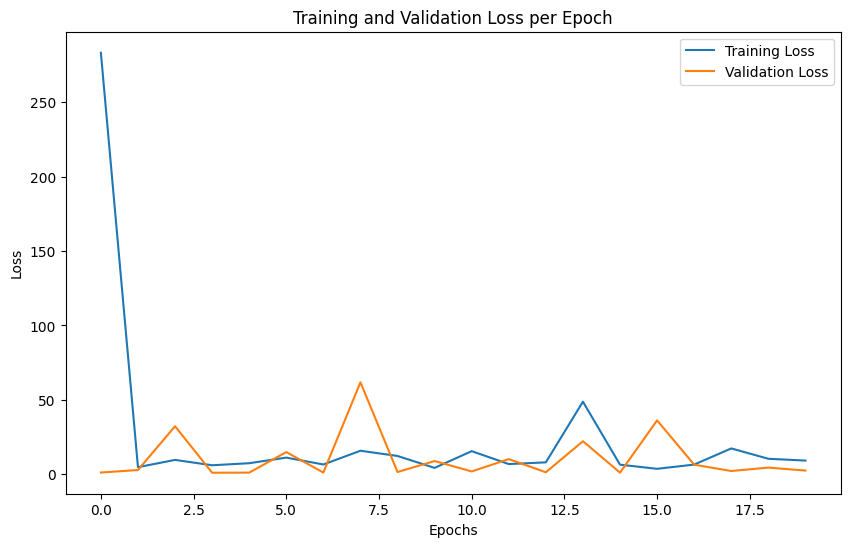

In [32]:
# Extracting training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the losses per epoch
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

## 3.3 Testing model

Testing is performed on a 6th day of trading not included in the training data

In [33]:
# Features and target for binary classification model
X_test_classification = df_test_puts.drop(columns=['close', 'is_buy'])  # Features for binary classification
y_test_classification = df_test_puts['is_buy']           # Binary target for classification

# Features and target for price prediction model
X_test_price = df_test_puts.drop(columns=['is_buy', 'close'])  # Features for price prediction
y_test_price_full = df_test_puts['close']                      # Target price for price prediction

In [34]:
y_pred_binary = (binary_classifier_puts.predict(X_test_classification).flatten() >= 0.5).astype(int)

# Calculate binary classifier metrics
binary_accuracy = accuracy_score(y_test_classification, y_pred_binary)
binary_precision = precision_score(y_test_classification, y_pred_binary)
binary_recall = recall_score(y_test_classification, y_pred_binary)
binary_f1 = f1_score(y_test_classification, y_pred_binary)

print("Binary Classifier Metrics:")
print(f"Accuracy: {binary_accuracy}")
print(f"Precision: {binary_precision}")
print(f"Recall: {binary_recall}")
print(f"F1-Score: {binary_f1}")


872/872 ━━━━━━━━━━━━━━━━━━━━ 0s 169us/step
Binary Classifier Metrics:
Accuracy: 0.957529926170167
Precision: 0.8435909301249421
Recall: 0.6827715355805244
F1-Score: 0.754709169944111


In [35]:
# Step 2: Filter Data for Stage 2 Price Prediction
purchasable_mask = (y_pred_binary == 1)  # Mask for options classified as "purchasable"

# Apply the mask to get features and target for price prediction
X_test_price_purchasable = X_test_price[purchasable_mask]
y_test_price = y_test_price_full[purchasable_mask]

In [36]:
# Step 3: Run Stage 2 Price Prediction
if len(X_test_price_purchasable) > 0:
    y_pred_price = price_prediction_model_puts.predict(X_test_price_purchasable)

    # Calculate regression metrics
    mse = mean_squared_error(y_test_price, y_pred_price)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_price, y_pred_price)
    r2 = r2_score(y_test_price, y_pred_price)

    print("\nPrice Prediction Model Metrics:")
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R-squared: {r2}")
else:
    print("\nNo 'purchasable' options found for price prediction in the 6th day test set.")

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step

Price Prediction Model Metrics:
Mean Squared Error: 401.43581974541235
Root Mean Squared Error: 20.03586333915792
Mean Absolute Error: 8.019726271604508
R-squared: 0.92310816721813


## 3.4 Hyperparam Tuning

### 3.4.1 Hyperparam Tuning (Binary Classifier)

In [42]:
# Define the model-building function for Random Search
def build_binary_classifier_model(units=28, learning_rate=1e-3):
    model = Sequential()
    
    # Define the input layer separately using Input()
    model.add(Input(shape=(14,)))
    
    # Hidden layer with Leaky ReLU activation (using `negative_slope` instead of `alpha`)
    model.add(Dense(units=units))
    model.add(LeakyReLU(negative_slope=0.01))
    
    # Output layer with 1 neuron and sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model with specified learning rate
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Wrap the model using KerasClassifier, passing the function as build_fn
binary_classifier = KerasClassifier(model=build_binary_classifier_model, verbose=0)


In [43]:
param_grid = {
    'model__units': [14, 28, 56],            # Number of neurons in the hidden layer
    'model__learning_rate': [1e-2, 1e-3, 1e-4],  # Learning rates to try
    'batch_size': [16, 32, 64],              # Batch sizes to try
    'epochs': [10, 20]                       # Number of epochs to train
}

In [44]:
from sklearn.model_selection import RandomizedSearchCV

# Initialize RandomizedSearchCV with the desired number of iterations
random_search = RandomizedSearchCV(estimator=binary_classifier, param_distributions=param_grid, 
                                   scoring='accuracy', cv=3, n_iter=10, random_state=42)

# Fit RandomizedSearchCV
X_train = df_train_puts.drop(columns=['close', 'is_buy'])  # Drop 'close' and 'is_buy' from features
y_train = df_train_puts['is_buy']  # Target for binary classification
random_search_result = random_search.fit(X_train, y_train)

# Get the best hyperparameters and score
print(f"Best Hyperparameters: {random_search_result.best_params_}")
print(f"Best Score: {random_search_result.best_score_}")


Best Hyperparameters: {'model__units': 56, 'model__learning_rate': 0.001, 'epochs': 20, 'batch_size': 32}
Best Score: 0.9623793216361398


### 3.4.2 Hyperparam Tuning (Price Prediction)

In [45]:
# Define the model-building function
def build_price_prediction_model(units1=28, units2=14, learning_rate=1e-3):
    model = Sequential()
    
    # Input and first hidden layer
    model.add(Input(shape=(14,)))
    model.add(Dense(units=units1))
    model.add(LeakyReLU(negative_slope=0.01))
    
    # Second hidden layer
    model.add(Dense(units=units2))
    model.add(LeakyReLU(negative_slope=0.01))
    
    # Output layer
    model.add(Dense(units=1))  # No activation function for regression
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

In [46]:
# Wrap the model with KerasRegressor
price_prediction_model = KerasRegressor(model=build_price_prediction_model, verbose=0)

In [47]:
param_grid = {
    'model__units1': [14, 28, 54],               # Number of neurons in the first hidden layer
    'model__units2': [7, 14, 28],                # Number of neurons in the second hidden layer
    'model__learning_rate': [1e-2, 1e-3, 1e-4],  # Learning rates to try
    'batch_size': [16, 32, 64],                  # Batch sizes to try
    'epochs': [10, 20]                           # Number of epochs
}

In [48]:
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=price_prediction_model, param_distributions=param_grid, 
                                   scoring='neg_mean_squared_error', n_iter=10, cv=3, random_state=42)

# Fit RandomizedSearchCV
X_train = df_train_puts.drop(columns=['close', 'is_buy'])  # Features for training
y_train = df_train_puts['close']  # Target prices for training
random_search_result = random_search.fit(X_train, y_train)


# Get the best hyperparameters and score
print(f"Best Hyperparameters: {random_search_result.best_params_}")
print(f"Best Score (Negative MSE): {random_search_result.best_score_}")


Best Hyperparameters: {'model__units2': 14, 'model__units1': 28, 'model__learning_rate': 0.001, 'epochs': 20, 'batch_size': 32}
Best Score (Negative MSE): -2900.4928174837805
